## GQA Question Engine

In [ ]:
import json
import networkx as nx
import matplotlib.pyplot as plt

def load_scene_graph(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

## All Images
# english_scene_graph_file = 'data/sceneGraphs/train_sceneGraphs.json'

## Just 3 Images
english_scene_graph_file = "data/sceneGraphs/extracted_image_data.json"

english_scene_graph_data = load_scene_graph(english_scene_graph_file)

{
    "1665235": {
        "attributes": [],
        "h": 194,
        "name": "ground",
        "relations": [
            {
                "name": "to the right of",
                "object": "2223553"
            },
            {
                "name": "to the right of",
                "object": "1855767"
            },
            {
                "name": "to the right of",
                "object": "2608901"
            },
            {
                "name": "to the right of",
                "object": "2444445"
            }
        ],
        "w": 257,
        "x": 144,
        "y": 179
    },
    "1734279": {
        "attributes": [],
        "h": 48,
        "name": "menu",
        "relations": [
            {
                "name": "to the left of",
                "object": "1941208"
            },
            {
                "name": "to the right of",
                "object": "2223553"
            },
            {
                "name": "to the right of",
       

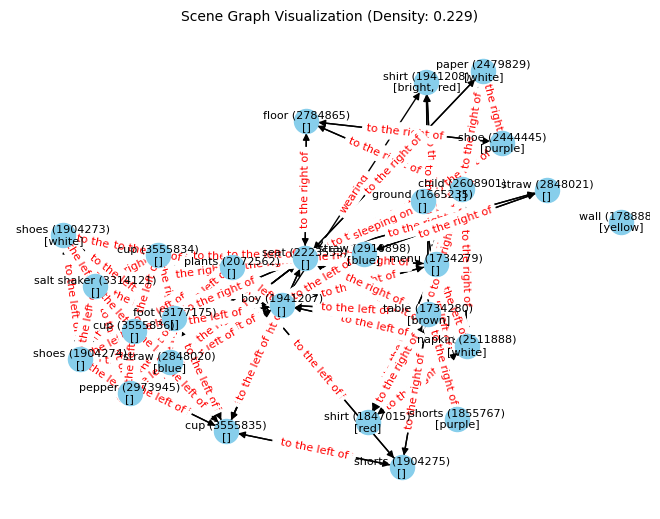

In [63]:
# Example image ID
# 2338159
# 2382734
# 2357213

image_id = "2357213"

if image_id in english_scene_graph_data:
    image_data = english_scene_graph_data[image_id]["objects"]
else:
    raise ValueError(f"Image ID {image_id} not found in the scene graph data")

print(json.dumps(image_data, sort_keys=True, indent=4))

# Create a graph
G = nx.DiGraph()

for obj_id, obj_data in image_data.items():
    obj_name = f'{obj_data["name"]} ({obj_id})'
    attributes = ', '.join(obj_data["attributes"]) if "attributes" in obj_data else ""
    label = f'{obj_name}\n[{attributes}]'
    
    # Add object node with attributes
    G.add_node(obj_id, label=label)
    
    # Add edges for relationships
    if "relations" in obj_data:
        for relation in obj_data["relations"]:
            target_obj = relation["object"]
            relation_name = relation["name"]
            G.add_edge(obj_id, target_obj, label=relation_name)

# Get graph density and node count to adjust layout and size
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
graph_density = nx.density(G)  # Density: edges / possible edges

# Dynamic scaling based on the number of nodes and edges
scale_factor = max(1, num_nodes / 30)  # Adjust based on node count
node_size = max(200, 300 / scale_factor)  # Dynamic node size
font_size = max(5, 8 / scale_factor)     # Dynamic font size
k_value = max(0.5, 1 / scale_factor)    # Dynamic spacing between nodes

# Define position layout (spring_layout) with dynamic k based on density
pos = nx.spring_layout(G, k=k_value)

# Draw nodes with dynamic size and labels with dynamic font size
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), 
        node_size=node_size, node_color='skyblue', font_size=font_size, font_weight='light')

# Draw edges with smaller labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=font_size)

# Display the plot with adjusted title size
plt.title(f"Scene Graph Visualization (Density: {graph_density:.3f})", fontsize=10)
plt.show()


In [64]:
import random
import csv

question_templates = {
    "attribute-based": [
        "What {attribute} is the {object_name}?{object_name} is {attribute}.",
        "What {attribute} does the {object_name} have?{object_name} has {attribute}.",
        "What is the {attribute} of the {object_name}?The {attribute} of {object_name} is {attribute}.",
    ],
    "relation-based": [
        "What object is {relation_name} to the {object_name}?The object {relation_name} to the {object_name} is {target_obj_name}.",
        "Which object does the {object_name} {relation_name}?The {object_name} {relation_name} the {target_obj_name}.",
        "What is {relation_name} to the {object_name}?{target_obj_name} is {relation_name} to {object_name}.",
        "Where is the {object_name} in relation to the {target_obj_name}?The {object_name} is {relation_name} to {target_obj_name}.",
    ]
}

question_templates = {
    "attribute-based": [
        "{attribute}ที่{object_name}มี?{object_name}เป็น{attribute}",
        "{object_name}มี{attribute}?{object_name}มี{attribute}",
        "{attribute}ของ{object_name}คืออะไร?{attribute}ของ{object_name}เป็น{attribute}",
    ],
    "relation-based": [
        "วัตถุอะไร {relation_name}กับ{object_name}?วัตถุที่{relation_name}กับ{object_name}คือ{target_obj_name}",
        "วัตถุใดที่{object_name}{relation_name}?{object_name}ทำ{relation_name}กับ{target_obj_name}",
        "อะไรคือ{relation_name}ของ{object_name}?{object_name}ทำ{relation_name}กับ{target_obj_name}",
        "{object_name}อยู่ที่ไหนเมื่อเปรียบเทียบกับ{target_obj_name}?{object_name}ทำ{relation_name}กับ{target_obj_name}",
    ]
}

# Generate questions from objects and their attributes
def generate_object_attribute_questions(objects):
    questions_data = []
    for obj_id, obj_data in objects.items():
        obj_name = obj_data['name']
        attributes = obj_data.get('attributes', [])
        
        for attribute in attributes:
            template = random.choice(question_templates["attribute-based"])
            question = template.format(attribute=attribute, object_name=obj_name)
            questions_data.append({
                'image_id': obj_id, 'object': obj_name, 'attribute': attribute, 
                'relation': '', 'target': '', 'question': question,
                'question_template': template
            })
    
    return questions_data

# Generate questions from object relations
def generate_relation_questions(objects):
    questions_data = []
    for obj_id, obj_data in objects.items():
        obj_name = obj_data['name']
        
        for relation in obj_data.get('relations', []):
            relation_name = relation['name']
            target_obj_id = relation['object']
            target_obj_name = objects[target_obj_id]['name']
            
            template = random.choice(question_templates["relation-based"])
            question = template.format(relation_name=relation_name, object_name=obj_name, target_obj_name=target_obj_name)
            questions_data.append({
                'image_id': obj_id, 'object': obj_name, 'attribute': '', 
                'relation': relation_name, 'target': target_obj_name, 'question': question,
                'question_template': template
            })
    
    return questions_data

def generate_questions(image_id, scene_graph_data):
    if image_id not in scene_graph_data:
        raise ValueError(f"Image ID {image_id} not found in the scene graph data")

    image_data = scene_graph_data[image_id]["objects"]
    
    attribute_questions_data = generate_object_attribute_questions(image_data)
    relation_questions_data = generate_relation_questions(image_data)
    
    all_questions_data = attribute_questions_data + relation_questions_data
    return all_questions_data

def save_questions_to_csv(scene_graph_data, num_images, file_path):
    questions_data_list = []
    
    for i, image_id in enumerate(scene_graph_data.keys()):
        if i >= num_images:
            break
        
        questions_data = generate_questions(image_id, scene_graph_data)
        
        questions_data_list.extend(questions_data)
    
    # Write all data to the CSV file
    with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['ImageId', 'Object', 'Attribute', 'Relation', 'Target', 'Question Template', 'Generated Question?Answer'])
        for data in questions_data_list:
            csvwriter.writerow([data['image_id'], data['object'], data['attribute'], data['relation'], data['target'], data['question_template'], data['question']])

    print(f"Questions and related data for {num_images} images saved to {file_path}")


In [65]:

file_path = 'generated/english_questions_with_data.csv'
num_images = 3

save_questions_to_csv(english_scene_graph_data, num_images, file_path)


Questions and related data for 3 images saved to generated/english_questions_with_data.csv


Prompt For Correcting Questions
```
Hi, I generated a question from scene graph data. They are still wrong. Can you help correct it?

please return it as a CSV file with two columns. The first column is the wrong old one. The second column is the newly corrected ones.

Here is the wrong question CSV file
```

## Thai Images

Creating Visual Genome from Thai Images

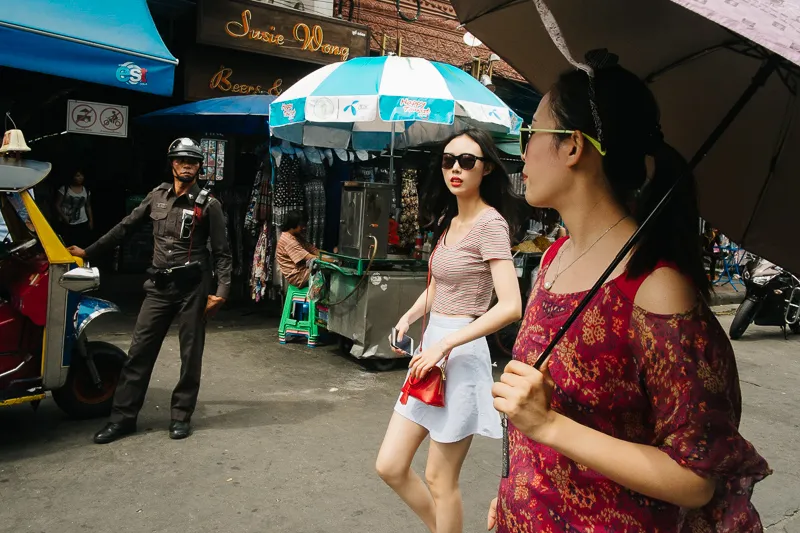

In [66]:
thai_scene_graph_data = {
    "image_001": {
        "size": {"width": 800, "height": 533},
        "location": "ตลาดในเมือง",
        "weather": "แดดแรง",
        "objects": {
            "คน_1": {
                "name": "ผู้หญิง",
                "attributes": [
                    "ใส่เสื้อแดง", 
                    "ใส่กระโปรงยีนส์"
                ],
                "relations": [
                    {"name": "ใส่", "object": "แว่นตากันแดด_1"},
                    {"name": "ถือ", "object": "ร่มลายดอกไม้_1"},
                    {"name": "เดินข้าง", "object": "คน_2"},
                    {"name": "หันหน้าไปทาง", "object": "รถตุ๊กตุ๊ก_1"},
                    {"name": "เดินหน้าร้าน", "object": "ร้านอาหาร_1"}
                ]
            },
            "แว่นตากันแดด_1": {
                "name": "แว่นตากันแดด",
                "attributes": [
                    "กันแดด"
                ],
                "relations": [
                    {"name": "ใส่โดย", "object": "คน_1"}
                ]
            },
            "ร่มลายดอกไม้_1": {
                "name": "ร่ม",
                "attributes": [
                    "ลายดอกไม้"
                ],
                "relations": [
                    {"name": "ถือโดย", "object": "คน_1"}
                ]
            },
            "คน_2": {
                "name": "ผู้หญิง",
                "attributes": [
                    "ใส่เสื้อชมพู", 
                    "ใส่รองเท้าส้นสูงสีขาว"
                ],
                "relations": [
                    {"name": "ถือ", "object": "กระเป๋าสะพาย_1"},
                    {"name": "เดินข้าง", "object": "คน_1"}
                ]
            },
            "กระเป๋าสะพาย_1": {
                "name": "กระเป๋าสะพาย",
                "attributes": [
                    "สีแดง"
                ],
                "relations": [
                    {"name": "ถือโดย", "object": "คน_2"}
                ]
            },
            "ตำรวจ_1": {
                "name": "ตำรวจ",
                "attributes": [
                    "ใส่ชุดตำรวจ", 
                    "ใส่หมวก"
                ],
                "relations": [
                    {"name": "ถือ", "object": "วิทยุสื่อสาร_1"},
                    {"name": "ยืนข้าง", "object": "รถตุ๊กตุ๊ก_1"},
                    {"name": "มองไปทาง", "object": "คน_2"},
                    {"name": "เดินตาม", "object": "คน_1"}
                ]
            },
            "วิทยุสื่อสาร_1": {
                "name": "วิทยุสื่อสาร",
                "attributes": [],
                "relations": [
                    {"name": "ถือโดย", "object": "ตำรวจ_1"}
                ]
            },
            "รถตุ๊กตุ๊ก_1": {
                "name": "รถตุ๊กตุ๊ก",
                "attributes": [
                    "สีน้ำเงิน-เหลือง", 
                    "ป้ายทะเบียนขาว"
                ],
                "relations": [
                    {"name": "จอดใกล้", "object": "แผงขายผลไม้"},
                    {"name": "อยู่ซ้ายของ", "object": "คน_2"},
                    {"name": "หันหน้าไปทาง", "object": "ร้านอาหาร_1"}
                ]
            },
            "ร้านอาหาร_1": {
                "name": "ร้านอาหาร",
                "attributes": [
                    "ป้ายเหลือง", 
                    "มีโต๊ะเก้าอี้นั่งด้านนอก", 
                    "ขายอาหารตามสั่ง"
                ],
                "relations": [
                    {"name": "อยู่ใกล้", "object": "แผงขายผลไม้"},
                    {"name": "อยู่หลัง", "object": "รถตุ๊กตุ๊ก_1"}
                ]
            },
            "แผงขายผลไม้": {
                "name": "แผงขายผลไม้",
                "attributes": [
                    "ผ้าฟ้ากันแดด", 
                    "ขายกล้วยกับส้ม", 
                    "อยู่ริมทาง"
                ],
                "relations": [
                    {"name": "อยู่ใกล้", "object": "ตำรวจ_1"},
                    {"name": "อยู่หน้าร้าน", "object": "ร้านอาหาร_1"}
                ]
            },
            "มอเตอร์ไซค์_1": {
                "name": "รถมอเตอร์ไซค์",
                "attributes": [
                    "สีดำ", 
                    "จอดบนฟุตบาท", 
                    "มีหมวกกันน็อกแดงแขวน"
                ],
                "relations": [
                    {"name": "จอดข้าง", "object": "คน_2"},
                    {"name": "จอดใกล้", "object": "ตำรวจ_1"}
                ]
            }
        }
    }
}


In [67]:

file_path = 'generated/thai_questions_with_data.csv'
num_images = 1
save_questions_to_csv(thai_scene_graph_data, num_images, file_path)


Questions and related data for 1 images saved to generated/thai_questions_with_data.csv
